## Chapter 3. Statistial Experiments and Significance Testing

The key idea of this chapter that humans tend to be fooled by randomness(to see pattern in data that is generated due random chance) so how to not be fooled?<br>
Is by doing hypothesis testing given a model that embodies the null hypothesis(random chance) what is the probability of obtaining results as unsual or exterme as the observed results.<br>
By comparing the resulted prob. to alpha(threshold of unusualness) this gives us that the observed pattern is statistically significant.<br>

Types of Hypothesis Tests:
- t-test for one numerical or one numerical with one categorical.
- Chi-test for two categorical variables.
- ANOVA Often used similarly to a t-test, but for more than two groups.<br>
There are other test but this what was discussed by the authors.

Import required packages

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt
import seaborn as sns

Define data path.

In [2]:
BREAST_CANCER = 'data/mine/breast_cancer.csv'
HEART_FAILURE = 'data/mine/heart_failure.csv'
MEDICAL_INSURANCE = 'data/mine/insurance.csv'
TELCO_CUST_CHURN = 'data/mine/telco-churn.csv'

In [3]:
insurance_df = pd.read_csv(MEDICAL_INSURANCE)

In [4]:
insurance_df.head()
insurance_df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [5]:
charges_sample = insurance_df[(insurance_df.region== 'southwest') | (insurance_df.region== 'northeast')][['charges','region']]
#northwest = insurance_df[insurance_df.region== 'northwest']['charges']

In [6]:
charges_sample

,charges,region
0,16884.92400,southwest
8,6406.41070,northeast
10,2721.32080,northeast
12,1826.84300,southwest
15,1837.23700,southwest
...,...,...
1329,10325.20600,southwest
1331,10795.93733,southwest
1332,11411.68500,southwest
1334,2205.98080,northeast


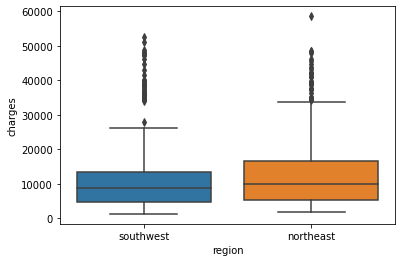

In [7]:
ax = sns.boxplot(x="region", y="charges", data=charges_sample)

In [8]:
mean_southwest= charges_sample[charges_sample.region== 'southwest']['charges'].mean()
mean_northeast=charges_sample[charges_sample.region== 'northeast']['charges'].mean()
print(mean_northeast - mean_southwest)

1059.4471390934905


As shown in boxplot and difference in mean that northeast have greater charges for medical insurance by 1059 USD so is it due random chance or there is real difference( look as the range of charges in northeast from the boxplot)

So first we need to formulate hypothesis

The null hypothesis: There is no difference between the two regions means (groups) and any difference is due chance<br>
The Alternative hypothesis: There is difference.<br>
This can be tested by permuatation test and t-test.

## Permutation Test

In [9]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
nA = charges_sample[charges_sample.region== 'southwest'].shape[0]
nB = charges_sample[charges_sample.region== 'northeast'].shape[0]

charges_sample.reset_index(drop=True,inplace=True)

perm_fun(charges_sample.charges,nA,nB)

1771.8153572195024

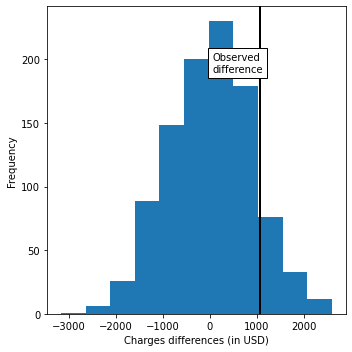

In [20]:
mean_perm_diff= [perm_fun(charges_sample.charges,nA,nB) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(mean_perm_diff, bins=11,)
ax.axvline(x = mean_northeast - mean_southwest, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Charges differences (in USD)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## t-test:
By setting alpha to 0.05 we start to calculate the p-value and t-test

In [21]:
aux_array =np.asarray(mean_perm_diff) >= (mean_northeast - mean_southwest)
print('the calculated p-value from perm test ' ,np.mean(aux_array))

the calculated p-value from perm test  0.116


In [22]:
res = stats.ttest_ind(charges_sample[charges_sample.region== 'southwest']['charges'],
                      charges_sample[charges_sample.region== 'northeast']['charges'],equal_var=True,
                    )

In [23]:
print('The calculated p-value from ttest ',res.pvalue)

The calculated p-value from ttest  0.23725708144582303


There is a difference from SciPy esitmation for the P-value and the calculated one from the Permuation Test but both suppert that the difference is due chance (P-value> aplha)

## ANOVA
we will do like the ttest but for multiple groups

In [32]:
charges_group = insurance_df[['region','charges']]

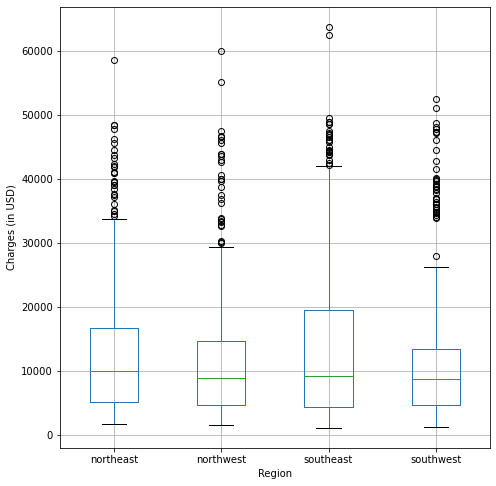

In [34]:
ax = charges_group.boxplot(by='region', column='charges',
                           figsize=(7, 7))
ax.set_xlabel('Region')
ax.set_ylabel('Charges (in USD)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [36]:
observed_variance = charges_group.groupby('region').mean().var()[0]

In [43]:
print('Observed means:', charges_group.groupby('region').mean())
print('Variance between group means:', observed_variance)

Observed means:                 charges
region                 
northeast  13406.384516
northwest  12417.575374
southeast  14735.411438
southwest  12346.937377
Variance between group means: 1245720.5332746778


In [44]:
def perm_anova(x):
    x = x.copy()
    x['charges'] = np.random.permutation(x['charges'].values)
    return x.groupby('region').mean().var()[0]

Pr(Prob) 0.03833333333333333


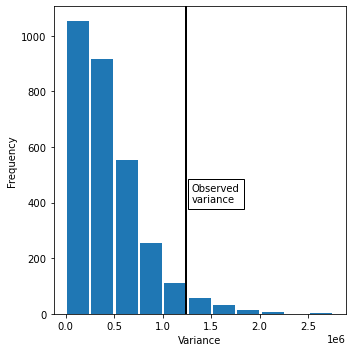

In [50]:
perm_variance = [perm_anova(charges_group) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(1.3e6, 400, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-statistic

In [65]:
# fit linear model using statsmodel because is gives more statistical info.
model = smf.ols('charges ~ region', data=insurance_df).fit()
                
aov_table = sm.stats.anova_lm(model)
#calculating the aov table for linear fitted model
print(aov_table)

              df        sum_sq       mean_sq         F    PR(>F)
region       3.0  1.300760e+09  4.335866e+08  2.969627  0.030893
Residual  1334.0  1.947735e+11  1.460071e+08       NaN       NaN


In [69]:
res = stats.f_oneway(insurance_df[insurance_df.region == 'northeast'].charges, 
                     insurance_df[insurance_df.region == 'northwest'].charges,
                     insurance_df[insurance_df.region == 'southeast'].charges,
                     insurance_df[insurance_df.region == 'southwest'].charges)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.4848
p-value: 0.0154
